# Build a scoring model (Short version)

### Missions:
- Transform the relevant variables for a classic supervised model (= feature engineering)
- Train a classic supervised model that meets the expectations of the trades
- Evaluate the performance of a classic supervised model
- Adapt the hyperparameters of a classic supervised learning model in order to improve it

### Dataset from : https://www.kaggle.com/c/home-credit-default-risk/data

### Interesting Kaggle :
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search

### Importing libraries and dataset

In [273]:
%%time
import numpy as np
from numpy import arange
from numpy import unique

import pandas as pd
pd.set_option('display.max_columns', None)  

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, neighbors


from imblearn.under_sampling import RandomUnderSampler

Wall time: 998 µs


In [157]:
application_train_path = '../application_train.csv'

#size of sample for cpu usage
n_sample = 10000

In [158]:
def load_dataset(path):
    df = pd.read_csv(path, sep=',', low_memory=False)
    
    #Cat columns and Numerical columns
    cat_columns = df.select_dtypes(include=['object', 'bool']).columns
    num_columns = df.select_dtypes(include=['int64', 'float64']).columns

    return cat_columns, num_columns, df

In [159]:
%%time
cat_columns, num_columns, df = load_dataset(application_train_path)

Wall time: 5.87 s


In [160]:
df.shape, len(cat_columns), len(num_columns)

((307511, 122), 16, 106)

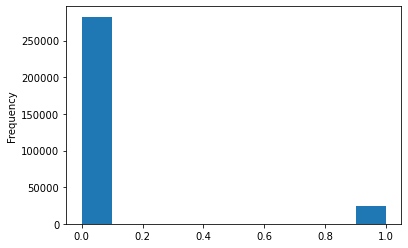

In [161]:
df['TARGET'].astype(int).plot.hist();

### Basic cleaning

In [162]:
#Cleaning days
df.iloc[:, 17:21] = df.iloc[:, 17:21].apply(lambda x: -1*x)
df.iloc[:, 17:21] = df.iloc[:, 17:21].replace(-365243, 0)

In [163]:
#Cleaning gender
df.CODE_GENDER = df.CODE_GENDER.replace('XNA', 'F')

### Encoding

In [164]:
categorical = pd.get_dummies(df[cat_columns]) #, dummy_na=True

In [165]:
numerical = df[num_columns]

In [166]:
df_encoded = pd.concat([numerical, categorical], axis=1)

### Sampling

In [167]:
df_samp = df_encoded.sample(n=n_sample)

### Imputing

In [168]:
%%time
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=2)
X = impute_knn.fit_transform(df_samp)
df_imp = pd.DataFrame(data=X, columns=df_samp.columns)

Wall time: 1min 19s


### Balancing

In [14]:
df_imp = pd.concat([df_imp['TARGET'],df_imp.drop('TARGET',axis=1)], axis=1)

In [15]:
x = df_imp.iloc[:,1:]
y = df_imp.iloc[:,0] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [16]:
%%time
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)

Wall time: 231 ms


In [17]:
df_prepared = x_train_new.join(y_train_new)

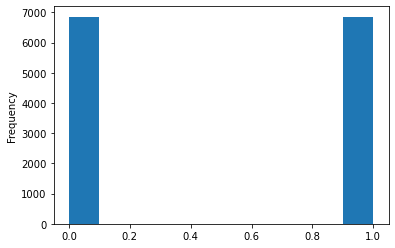

In [18]:
df_prepared['TARGET'].astype(int).plot.hist();

### Checkpoint : Save dataframe

In [19]:
df_prepared.to_csv('Encoded Cleaned Imputed dataframe.csv')

In [310]:
try:
    df_prepared
except NameError:
    df_prepared = pd.read_csv('Encoded Cleaned Imputed dataframe.csv', sep=',')

In [311]:
x = df_prepared.iloc[:,0:-1]
y = df_prepared.iloc[:,-1] 

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Baseline

In [312]:
%%time 
strategies = {'uniform', 'stratified', 'most_frequent'}
for strategy in strategies:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x, y)
    score = dummy_clf.score(x, y)
    print('>Score for strategy', strategy, 'is %0.3f.' % score)

>Score for strategy most_frequent is 0.500.
>Score for strategy uniform is 0.504.
>Score for strategy stratified is 0.500.
Wall time: 130 ms


### Testing models

In [313]:
x = df_prepared.iloc[:,0:-1]
y = df_prepared.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [24]:
%%time
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    metric = make_scorer(f2_measure)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

models, names = get_models()
results = list()

for i in range(len(models)):
    pipeline = Pipeline(steps=[('m',models[i])])
    scores = evaluate_model(x_train, y_train, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.593 (0.025)
>LDA 0.751 (0.012)
>NB 0.739 (0.015)
>SVM 0.616 (0.022)
Wall time: 2min 34s


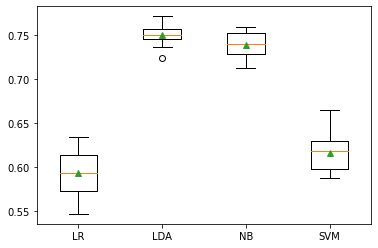

In [26]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Model choosen : LDA

In [316]:
def LDA(x_train, y_train):
    model = LinearDiscriminantAnalysis()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    metric = make_scorer(f2_measure)
    scores = cross_val_score(model, x_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    print('>LDA score : %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

### Features selection

### Variance within features

>For threshold=0.00, Features left=234
>For threshold=0.01, Features left=123
>For threshold=0.02, Features left=96
>For threshold=0.03, Features left=83
>For threshold=0.04, Features left=76
>For threshold=0.05, Features left=72
>For threshold=0.06, Features left=67
>For threshold=0.07, Features left=64
>For threshold=0.08, Features left=61
>For threshold=0.09, Features left=61
>For threshold=0.10, Features left=58


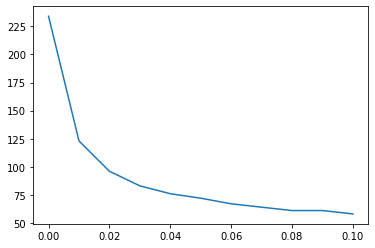

Wall time: 800 ms


In [28]:
%%time
from numpy import arange
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot

thresholds = arange(0.0, 0.11, 0.01)

results = list()
for t in thresholds:
    transform = VarianceThreshold(threshold=t)
    X_sel = transform.fit_transform(df_prepared)
    n_features = X_sel.shape[1]
    print('>For threshold=%.2f, Features left=%d' % (t, n_features))
    results.append(n_features)

pyplot.plot(thresholds, results)
pyplot.show()

### RFE LR

In [48]:
%%time
model = LogisticRegression(max_iter=500)
rfe = RFE(model, 123)
fit = rfe.fit(x, y)
print("Num Features: %s" % (fit.n_features_))
print("Feature Ranking: %s" % (fit.ranking_))

G:\Logiciels\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=123 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Num Features: 123
Feature Ranking: [  1   1   1   1   1   1  88   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1  79  83   1   1   1   1   1   1  59  24   1   1 109
   1   1   1   3   1  36  53  73  25  40  23   1   1 111   1   1   1   1
   1  39  52  71  18  64  26   1   1  98   1   1   1   1   1  41  50  68
  22  14   1   1   1   1   1 118   1 116  28   1 100  12  74 113  77 114
  32  31  61 112 108  21 102  69  89   4  49   1   1   1   1   1   1   1
   1   1   1   1  87   1   1 110  57  11   1   1 120   1 122   1   1 117
 115   1  82   1   1   1   1   1   6   1   1 119   1  37   1   1  13   1
   1   1  16   1   1   1  34   1  38   1  62   1  76  93  67   1  97   8
  70   9   2   1   1   1   5   1  45  56   1   1  63   1  85   1  29  43
  35   1  51  86   1  96  48  72 121  46   1  30 105  92  78 103  15  47
   1  81 107   7  65   1  20  42  90  99   1   1  58 101   1  55  75  84
  27   1 104  91  94   1 106   1  19   1   1   1  95   1   1   1   1  60
  17  33  54  44

In [49]:
selected_columns = []
for i in range(0, len(x.columns)):
    if(fit.support_[i] == True):
        selected_columns.append(x.columns[i])
len(selected_columns)    

123

In [50]:
df_selected = df_prepared[selected_columns]
df_selected = df_selected.join(y)

### Checkpoint : Save dataframe

In [51]:
df_selected.to_csv('Encoded Cleaned Imputed Selected dataframe.csv')

In [52]:
try:
    df_selected
except NameError:
    df_selected = pd.read_csv('Encoded Cleaned Imputed Selected dataframe.csv', sep=',')

In [53]:
x = df_selected.iloc[:,0:-1]
y = df_selected.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [329]:
clf = LinearDiscriminantAnalysis()
clf.fit(x_train, y_train)
expected = y_test
redicted = clf.predict(x_test)
conf_matrix = metrics.confusion_matrix(expected, predicted)
print(conf_matrix)
print(clf.score(x_train, y_train))

[[ 110 1615]
 [ 102 1619]]
0.5159636222910217


### Adding new features

In [66]:
import featuretools as ft

In [214]:
%%time
app_train = pd.read_csv('../application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:10000, :]
app_test = pd.read_csv('../application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:10000, :]
bureau = pd.read_csv('../bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:10000, :]
bureau_balance = pd.read_csv('../bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:10000, :]
cash = pd.read_csv('../POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
credit = pd.read_csv('../credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
previous = pd.read_csv('../previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]
installments = pd.read_csv('../installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:10000, :]

Wall time: 1min 10s


In [215]:
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

app = app_train.append(app_test, ignore_index = True)

In [216]:
app

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0          100002     1.0         Cash loans           M            N   
1          100003     0.0         Cash loans           F            N   
2          100004     0.0    Revolving loans           M            Y   
3          100006     0.0         Cash loans           F            N   
4          100007     0.0         Cash loans           M            N   
...           ...     ...                ...         ...          ...   
19997      172556     NaN         Cash loans           M            Y   
19998      172562     NaN         Cash loans           F            N   
19999      172570     NaN         Cash loans           M            N   
20000      172574     NaN         Cash loans           F            N   
20001      172575     NaN         Cash loans           F            N   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                   Y             0          202500.0    406597.5   
1                   N             0          270000.0   1293502.5   
2                   Y             0           67500.0    135000.0   
3                   Y             0          135000.0    312682.5   
4                   Y             0          121500.0    513000.0   
...               ...           ...               ...         ...   
19997               N             1          180000.0    500490.0   
19998               Y             0          202500.0    523152.0   
19999               Y             1          382500.0    967500.0   
20000               N             1          112500.0    539100.0   
20001               Y             0          157500.0    522900.0   

       AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0          24700.5         351000.0   Unaccompanied               Working   
1          35698.5        1129500.0          Family         State servant   
2           6750.0         135000.0   Unaccompanied               Working   
3          29686.5         297000.0   Unaccompanied               Working   
4          21865.5         513000.0   Unaccompanied               Working   
...            ...              ...             ...                   ...   
19997      52555.5         450000.0   Unaccompanied  Commercial associate   
19998      37336.5         463500.0   Unaccompanied         State servant   
19999      31338.0         967500.0          Family         State servant   
20000      22837.5         450000.0   Unaccompanied  Commercial associate   
20001      17986.5         315000.0   Unaccompanied  Commercial associate   

                 NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0      Secondary / secondary special  Single / not married   
1                   Higher education               Married   
2      Secondary / secondary special  Single / not married   
3      Secondary / secondary special        Civil marriage   
4      Secondary / secondary special  Single / not married   
...                              ...                   ...   
19997  Secondary / secondary special               Married   
19998  Secondary / secondary special                 Widow   
19999               Higher education               Married   
20000               Higher education               Married   
20001  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0        House / apartment                    0.018801       -9461   
1        House / apartment                    0.003541      -16765   
2        House / apartment                    0.010032      -19046   
3        House / apartment                    0.008019      -19005   
4        House / apartment                    0.028663      -19932   
...                    ...                         ...         ...   
19997  Municipal apartment                    0.046220      -15040   
19998    House / apartment                    0.032561      -17225   
1

In [217]:
es = ft.EntitySet(id = 'clients')

In [218]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

In [219]:
# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

In [220]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [221]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 20002, Columns: 123]
    bureau [Rows: 10001, Columns: 17]
    previous [Rows: 10001, Columns: 37]
    bureau_balance [Rows: 10001, Columns: 4]
    cash [Rows: 10001, Columns: 9]
    installments [Rows: 10001, Columns: 9]
    credit [Rows: 10001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [222]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(30)

name         type  dask_compatible  koalas_compatible  \
0               skew  aggregation            False              False   
1   time_since_first  aggregation            False              False   
2              trend  aggregation            False              False   
3   avg_time_between  aggregation            False              False   
4               last  aggregation            False              False   
5                min  aggregation             True               True   
6                max  aggregation             True               True   
7       percent_true  aggregation             True              False   
8                all  aggregation             True              False   
9              first  aggregation            False              False   
10     n_most_common  aggregation            False              False   
11               sum  aggregation             True               True   
12               any  aggregation             True              False   
13              mode  aggregation            False              False   
14           entropy  aggregation            False              False   
15            median  aggregation            False              False   
16   time_since_last  aggregation            False              False   
17          num_true  aggregation             True              False   
18               std  aggregation             True               True   
19        num_unique  aggregation             True               True   
20             count  aggregation             True               True   
21              mean  aggregation             True               True   

                                                                        description  
0   Computes the extent to which a distribution differs from a normal distribution.  
1                Calculates the time elapsed since the first datetime (in seconds).  
2                                     Calculates the trend of a variable over time.  
3                Computes the average number of seconds between consecutive events.  
4                                              Determines the last value in a list.  
5                             Calculates the smallest value, ignoring `NaN` values.  
6                              Calculates the highest value, ignoring `NaN` values.  
7                                          Determines the percent of `True` values.  
8                                    Calculates if all values are 'True' in a list.  
9                                             Determines the first value in a list.  
10                                         Determines the `n` most common elements.  
11                                   Calculates the total addition, ignoring `NaN`.  
12                                     Determines if any value is 'True' in a list.  
13                                     Determines the most commonly repeated value.  
14                                Calculates the entropy for a categorical variable  
15                            Determines the middlemost number in a list of values.  
16        Calculates the time elapsed since the last datetime (default in seconds).  
17                                              Counts the number of `True` values.  
18              Computes the dispersion relative to the mean value, ignoring `NaN`.  
19                 Determines the number of distinct values, ignoring `NaN` values.  
20                          Determines the total number of values, excluding `NaN`.  
21                                       Computes the average for a list of values.

In [223]:
primitives[primitives['type'] == 'transform'].head(30)


name       type  dask_compatible  \
22            greater_than_equal_to  transform             True   
23                 less_than_scalar  transform             True   
24                modulo_by_feature  transform             True   
25                             diff  transform            False   
26                          is_null  transform             True   
27          multiply_numeric_scalar  transform             True   
28                             week  transform             True   
29                              age  transform             True   
30                           minute  transform             True   
31                divide_by_feature  transform             True   
32                        not_equal  transform             True   
33                       time_since  transform             True   
34                              day  transform             True   
35                   divide_numeric  transform             True   
36              greater_than_scalar  transform             True   
37              time_since_previous  transform            False   
38                          cum_max  transform            False   
39                          cum_sum  transform            False   
40                 multiply_numeric  transform             True   
41                           second  transform             True   
42                           negate  transform             True   
43                      add_numeric  transform             True   
44  scalar_subtract_numeric_feature  transform             True   
45                             year  transform             True   
46                          cum_min  transform            False   
47                     equal_scalar  transform             True   
48        less_than_equal_to_scalar  transform             True   
49                   num_characters  transform             True   
50                        haversine  transform            False   
51                               or  transform             True   

    koalas_compatible  \
22               True   
23               True   
24               True   
25              False   
26               True   
27               True   
28               True   
29              False   
30               True   
31               True   
32              False   
33              False   
34               True   
35               True   
36               True   
37              False   
38              False   
39              False   
40               True   
41               True   
42               True   
43               True   
44               True   
45               True   
46              False   
47               True   
48               True   
49               True   
50              False   
51               True   

                                                                    description  
22  Determines if values in one list are greater than or equal to another list.  
23                           Determines if values are less than a given scalar.  
24                   Return the modulo of a scalar by each element in the list.  
25                   Compute the difference between the value in a list and the  
26                                               Determines if a value is null.  
27                               Multiply each element in the list by a scalar.  
28                             Determines the week of the year from a datetime.  
29               Calculates the age in years as a floating point number given a  
30                                  Determines the minutes value of a datetime.  
31                                   Divide a scalar by each value in the list.  
32              Determines if values in one list are not equal to another list.  
33                 Calculates time from a value to a specified cutoff datetime.  
34                             Determines the day of the month from a datetime.  
35                           

In [224]:
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

In [225]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 2221 features
Elapsed: 00:00 | Progress:   1%|          

G:\Logiciels\Anaconda3\lib\site-packages\featuretools\synthesis\dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['day', 'haversine', 'month', 'num_characters', 'num_words', 'weekday', 'year']
  agg_primitives: ['percent_true']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Elapsed: 01:12 | Progress: 100%|██████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [226]:
df_train = feature_matrix[feature_matrix.set=='train'].drop(['set'], axis=1)

In [227]:
df_train

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
...            ...                ...         ...          ...   
111630         0.0         Cash loans           F            Y   
111631         0.0         Cash loans           M            Y   
111632         0.0         Cash loans           F            N   
111633         0.0         Cash loans           M            Y   
111634         0.0         Cash loans           F            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
...                    ...           ...               ...         ...   
111630                   Y             0          166500.0   1006920.0   
111631                   Y             0          225000.0    497520.0   
111632                   N             0          360000.0    348264.0   
111633                   N             0           94500.0    355536.0   
111634                   N             0          225000.0    675000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
100002          24700.5         351000.0   Unaccompanied   
100003          35698.5        1129500.0          Family   
100004           6750.0         135000.0   Unaccompanied   
100006          29686.5         297000.0   Unaccompanied   
100007          21865.5         513000.0   Unaccompanied   
...                 ...              ...             ...   
111630          51543.0         900000.0   Unaccompanied   
111631          53581.5         450000.0   Unaccompanied   
111632          27643.5         315000.0   Unaccompanied   
111633          18742.5         270000.0   Unaccompanied   
111634          19737.0         675000.0   Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
...                          ...                            ...   
111630      Commercial associate  Secondary / secondary special   
111631                   Working               Higher education   
111632      Commercial associate  Secondary / secondary special   
111633                   Working  Secondary / secondary special   
111634                 Pensioner  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
...                          ...                ...   
111630                   Married  House / apartment   
111631                   Married  House / 

In [228]:
#Cleaning days
df_train.iloc[:, 17:21] = df_train.iloc[:, 17:21].apply(lambda x: -1*x)
df_train.iloc[:, 17:21] = df_train.iloc[:, 17:21].replace(-365243, 0)

In [229]:
#Cleaning gender
df_train.CODE_GENDER = df_train.CODE_GENDER.replace('XNA', 'F')

### Encoding

In [230]:
cat_columns = df_train.select_dtypes(include=['object', 'bool']).columns
num_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

In [231]:
categorical = pd.get_dummies(df_train[cat_columns]) #, dummy_na=True

In [232]:
numerical = df_train[num_columns]

In [233]:
df_encoded = pd.concat([numerical, categorical], axis=1)

### Sampling

In [246]:
df_samp = df_encoded.sample(n=10000)

### Imputing

In [258]:
df_samp = df_samp.dropna(axis=1, how='all')

In [259]:
df_samp.shape

(10000, 2386)

In [260]:
%%time
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=2)
X = impute_knn.fit_transform(df_samp)
df_imp = pd.DataFrame(data=X, columns=df_samp.columns)

Wall time: 47min 57s


### Balancing

In [261]:
df_imp = pd.concat([df_imp['TARGET'],df_imp.drop('TARGET',axis=1)], axis=1)

In [262]:
x = df_imp.iloc[:,1:]
y = df_imp.iloc[:,0] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [263]:
%%time
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
x_train_new, y_train_new = sm.fit_sample(x_train, y_train)

Wall time: 4.12 s


In [264]:
df_prepared = x_train_new.join(y_train_new)

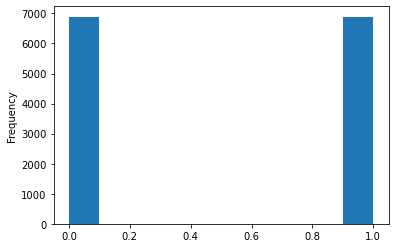

In [265]:
df_prepared['TARGET'].astype(int).plot.hist();

In [271]:
df_prepared.to_csv('Encoded Cleaned Imputed dataframe matrix.csv')

### Model testing big matrix

In [266]:
x = df_prepared.iloc[:,0:-1]
y = df_prepared.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [267]:
%%time
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    metric = make_scorer(f2_measure)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

models, names = get_models()
results = list()

for i in range(len(models)):
    pipeline = Pipeline(steps=[('m',models[i])])
    scores = evaluate_model(x_train, y_train, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.712 (0.012)
>LDA 0.712 (0.196)
>NB 0.816 (0.004)
>SVM 0.714 (0.017)
Wall time: 25min


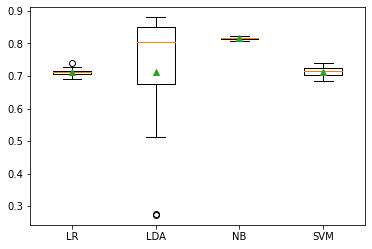

In [268]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [286]:
%%time
nb_classifier = GaussianNB()

metric = make_scorer(f2_measure)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=cv,
                 verbose=1, 
                 scoring=metric) 
gs_NB.fit(x_train, y_train)

gs_NB.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 23.7min finished


Wall time: 23min 42s


{'var_smoothing': 1.0}

In [289]:
gs_NB.best_score_

0.82775913524227

In [292]:
expected = y_test
predicted = gs_NB.predict(x_test)

conf_matrix = metrics.confusion_matrix(expected, predicted)

In [293]:
conf_matrix

array([[  53, 1656],
       [  29, 1708]], dtype=int64)

In [297]:
def f05_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)

In [303]:
%%time
nb_classifier = GaussianNB()

metric = make_scorer(f05_measure)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=cv,
                 verbose=1, 
                 scoring=metric) 
gs_NB.fit(x_train, y_train)

gs_NB.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 23.8min finished


Wall time: 23min 50s


{'var_smoothing': 2.310129700083158e-07}

In [304]:
expected = y_test
predicted = gs_NB.predict(x_test)

conf_matrix = metrics.confusion_matrix(expected, predicted)

In [305]:
conf_matrix

array([[ 142, 1567],
       [  70, 1667]], dtype=int64)

In [308]:
y_test.value_counts()

1.0    1737
0.0    1709
Name: TARGET, dtype: int64

In [309]:
%%time
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

models, names = get_models()
results = list()

for i in range(len(models)):
    pipeline = Pipeline(steps=[('m',models[i])])
    scores = evaluate_model(x_train, y_train, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.664 (0.012)
>LDA 0.681 (0.073)
>NB 0.517 (0.004)
>SVM 0.574 (0.009)
Wall time: 29min 13s
